**Imports**

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import random
import re

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix

## Scraping reddit for posts from the Soccer and NBA subreddits

**Function and scraping code from Katie Hickock**

In [64]:
def extract_reddit(res): # only make one df at atime          
    if res.status_code == 200:         
        posts = res.json()['data'] # posts is a list         
        df = pd.DataFrame(posts)[['subreddit', 'title', 'selftext', 'created_utc']] # appends to df          
    return df

In [65]:
### Code on behalf of Katie Hickcock
# df_s= pd.DataFrame() # want to append function df to empty ALL POSTS df

# subreddit= 'soccer'

# url = 'https://api.pushshift.io/reddit/search/submission/'
# params = {'subreddit': subreddit, 'size': 100} # params


# for i in range(20): # should give 20 times * 100 posts so 2000 posts
#     time.sleep(10) # does task every sleep(#) seconds
    
#     res = requests.get(url, params) 
#     func_df= extract_reddit(res) # df made at each i
#     params['before'] = func_df.iloc[-1]['created_utc'] # the last time data was taken from online
#     # params['before']= last_time
    
#     df_s= df_s.append(func_df, ignore_index= True)

# df_s.info()

In [66]:
### Code on behalf of Katie Hickcock
# df_b= pd.DataFrame() # want to append function df to empty ALL POSTS df

# subreddit= 'NBA'

# url = 'https://api.pushshift.io/reddit/search/submission/'
# params = {'subreddit': subreddit, 'size': 100} # params


# for i in range(20): # should give 20 times * 100 posts so 2000 posts
#     time.sleep(10) # does task every sleep(#) seconds
    
#     res = requests.get(url, params) 
#     func_df= extract_reddit(res) # df made at each i
#     params['before'] = func_df.iloc[-1]['created_utc'] # the last time data was taken from online
#     # params['before']= last_time
    
#     df_b= df_b.append(func_df, ignore_index= True)

# df_b.info()

## Saving and reloading the data so that it is stored

In [67]:
# df_s.to_csv(r'C:\Users\Dask\Documents\Code\dsi\project3\project_3\Data\df_s.csv')
# df_b.to_csv(r'C:\Users\Dask\Documents\Code\dsi\project3\project_3\Data\df_b.csv)

In [68]:
df_s = pd.read_csv(r'C:\Users\Dask\Documents\Code\dsi\project3\project_3\Data\dfs.csv')
df_b = pd.read_csv(r'C:\Users\Dask\Documents\Code\dsi\project3\project_3\Data\dfb.csv')

**Dropping unnecessary columns and setting titles to lowercase**

In [69]:
#dropping unneeded columns
df_s = df_s.drop(columns = 'Unnamed: 0')
df_b = df_b.drop(columns = 'Unnamed: 0')

In [70]:
#Making the titles for both subreddits all lowercase
df_s['title'] = df_s['title'].str.lower()
df_b['title'] = df_b['title'].str.lower()

**Checking for null values in titles and body**

In [71]:
#Checking for null values in the body of the posts on each subreddit
df_b['selftext'].isnull().value_counts(), df_s['selftext'].isnull().value_counts()

(False    1332
 True      660
 Name: selftext, dtype: int64,
 True     1693
 False     306
 Name: selftext, dtype: int64)

In [72]:
#checking for null values in the titles of the posts of each subreddit
df_s['title'].isnull().value_counts(), df_b['title'].isnull().value_counts()

(False    1999
 Name: title, dtype: int64,
 False    1992
 Name: title, dtype: int64)

In [73]:
#checking for posts with removed/deleted titles
sum(df_s['title'] == '[removed]'), sum(df_b['title'] == '[removed]')

(0, 0)

In [74]:
sum(df_s['title'] == '[deleted]'), sum(df_b['title'] == '[deleted]')

(0, 0)

**Combining the dataframes into one for modeling purposes**

In [75]:
#Creating a new Dataframe of both subreddits combined, with subreddits mapped to values 1 or 0 and storing it as a new csv
subs_df = pd.concat([df_s, df_b])

In [76]:
subs_df.to_csv(r'C:\Users\Dask\Documents\Code\dsi\project3\project_3\Data\combined_df.csv')

**EDA word counts and visuals**

In [77]:
#Average title Length
round(df_s['title'].str.count(' ').add(1).mean(), 0), round(df_b['title'].str.count(' ').add(1).mean(), 0)

(16.0, 16.0)

**Tokenizing and Lemmatizing**

In [78]:
#tokenized soccer title column
s_tokens = df_s['title'].apply(word_tokenize)
s_tokens.head()

0                                  [remember, this, ?]
1    [amazon, buys, napoli, in, 2026, ?, bezos, rea...
2    [messis, ,, lewandowskis, and, ronaldos, votes...
3    [the, beginning, of, my, soccer, training, vlo...
4    [reunião, nesta, terça, define, os, protocolos...
Name: title, dtype: object

In [79]:
#lemmatized basketball title column
b_tokens = df_b['title'].apply(word_tokenize)
b_tokens.head()

0    [[, post, game, thread, ], the, miami, heat, (...
1    [[, post, game, thread, ], the, miami, heat, (...
2    [tobias, harris, is, one, of, the, worst, play...
3    [who, do, you, think, is, the, ugliest, curren...
4    [would, the, lakers, be, a, better, team, if, ...
Name: title, dtype: object

In [80]:
lemmatizer = WordNetLemmatizer()

In [81]:
#lemmatized soccer title column
lem_s = [lemmatizer.lemmatize(token) for token in df_s['title']]

In [82]:
#lemmatized basketball title column
lem_b = [lemmatizer.lemmatize(token) for token in df_b['title']]

**Creating some helpful EDA visuals**

In [83]:
# 50 most popular words for each subreddit

In [84]:
cv = CountVectorizer(stop_words = 'english')

In [85]:
corpus_s = df_s['title']

In [86]:
word_count_vec_s = cv.fit_transform(corpus_s)

In [87]:
vector_s = cv.transform(corpus_s)

In [88]:
counts_s = pd.DataFrame(word_count_vec_s.todense(), columns = cv.get_feature_names())

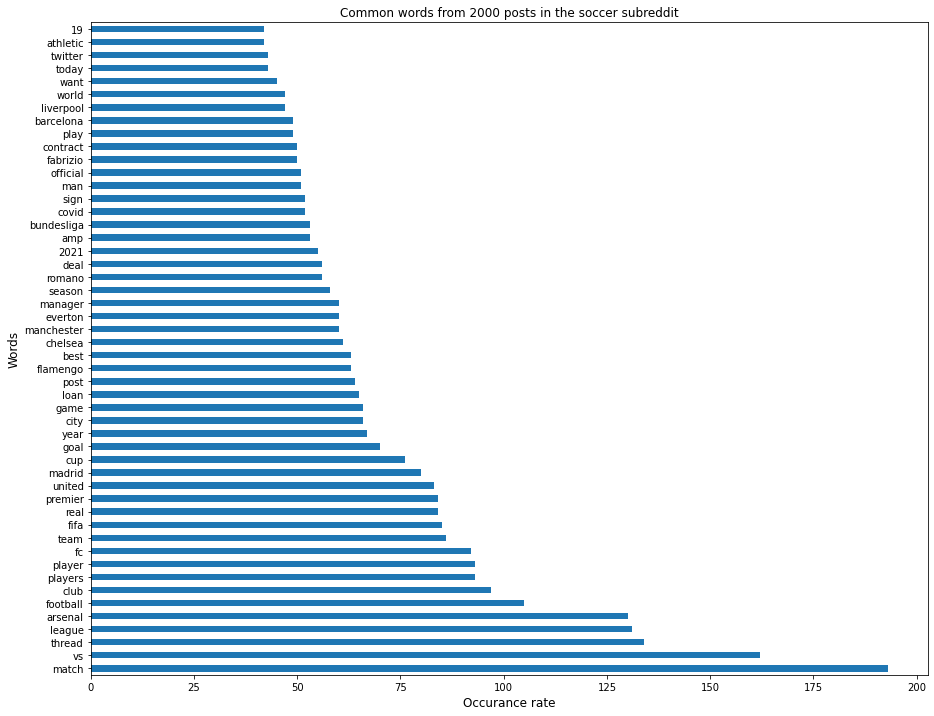

In [89]:
#50 most popular words in soccer titles
plt.figure(figsize = (15,12))
counts_s.sum().sort_values(ascending=False).head(50).plot(kind='barh')
plt.xlabel('Occurance rate', fontsize = 12)
plt.ylabel('Words', fontsize = 12)
plt.title('Common words from 2000 posts in the soccer subreddit', fontsize = 12);

#plt.savefig('soccer_common_words.jpg')

In [90]:
corpus_b = df_b['title']

In [91]:
word_count_vec_b = cv.fit_transform(corpus_b)

In [92]:
vector_b = cv.transform(corpus_b)

In [93]:
counts_b = pd.DataFrame(word_count_vec_b.todense(), columns = cv.get_feature_names())

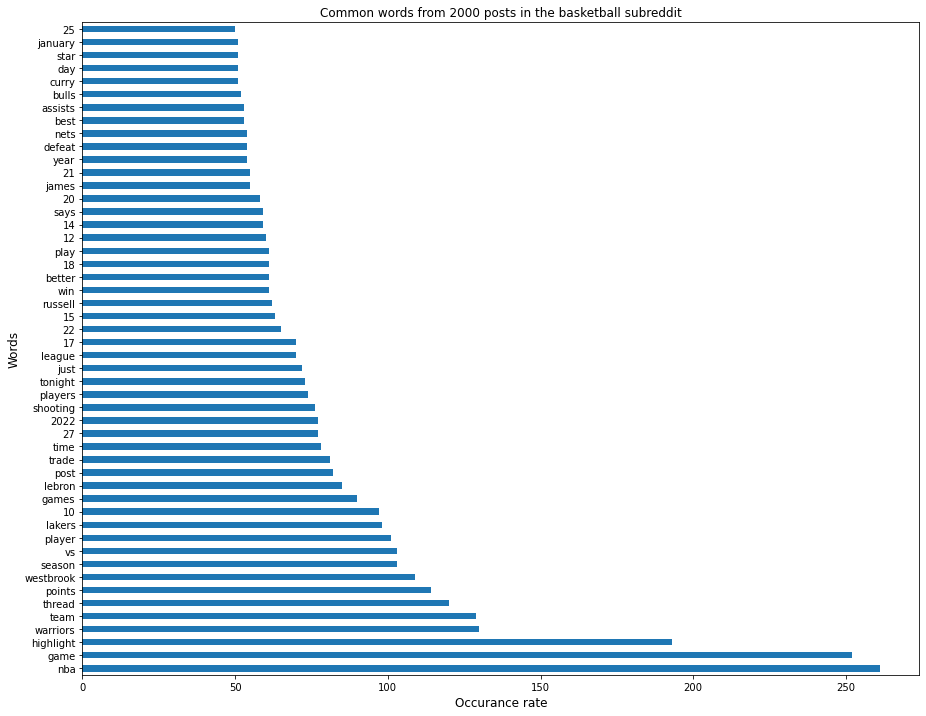

In [94]:
#50 most popular words in basketball titles
plt.figure(figsize = (15,12))
counts_b.sum().sort_values(ascending=False).head(50).plot(kind='barh')
plt.xlabel('Occurance rate', fontsize = 12)
plt.ylabel('Words', fontsize = 12)
plt.title('Common words from 2000 posts in the basketball subreddit', fontsize = 12);

#plt.savefig('Basketball_common_words.jpg')

**Frequency of certain terms**

In [95]:
#code to find counts of words existing in both subreddits
sum(counts_s['league']), sum(counts_b['league'])

(131, 70)

In [96]:
# DF of counts taken of words in both subreddits
counts_df = pd.DataFrame(
    {'Word':['Game', 'Match', 'Player', 'Goal', 'league', 'Win', 'loss', 'big', 'Spurs', '2022', '2021', 'Score'], 
     'Soccer':[66, 193, 93, 70, 131, 25, 5, 15, 22, 24, 55, 5], 
     'Basketball':[252, 4, 101, 3, 70, 61, 18, 21, 12, 77, 12, 7]})
counts_df = counts_df.set_index('Word')
counts_df

,Soccer,Basketball
Word,,
Game,66,252
Match,193,4
Player,93,101
Goal,70,3
league,131,70
Win,25,61
loss,5,18
big,15,21
Spurs,22,12


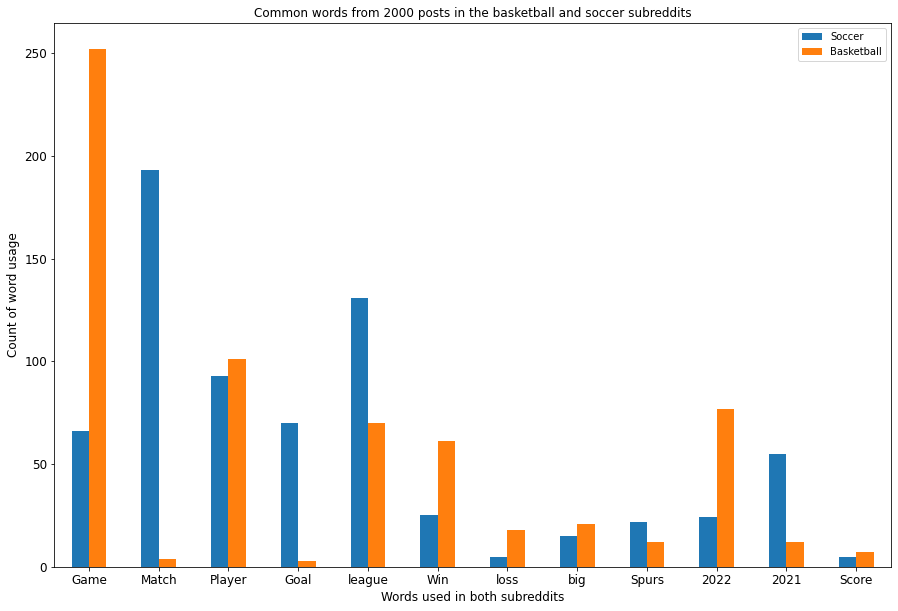

In [97]:
# Graph of counts of words found in both subreddits
counts_df[['Soccer','Basketball']].plot(kind='bar', figsize=(15, 10), fontsize=12)
plt.xlabel('Words used in both subreddits', fontsize = 12)
plt.xticks(rotation = 0)
plt.ylabel('Count of word usage', fontsize = 12)
plt.title('Common words from 2000 posts in the basketball and soccer subreddits', fontsize = 12);

#plt.savefig('words_from_both.jpg')

# Modeling

**Setting up X and y variables for models**

In [98]:
X = subs_df['title']
y = subs_df['subreddit']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify=y,
                                                    test_size = 0.2)

**Naive Bayes Model**

In [100]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [101]:
pipe.fit(X_train, y_train)

pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9874686716791979, 0.9624530663329162)

**Logistic Regression Model**

In [102]:
pipe2 = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [103]:
pipe2.fit(X_train, y_train)

pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(0.9971804511278195, 0.9524405506883604)

**Random Forest Model**

In [104]:
rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()

In [105]:
pipe_rfc = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier())
])

In [106]:
rfc_scores = cross_val_score(pipe_rfc, X_train, y_train)
print(rfc_scores)
print(rfc_scores.mean())

[0.91079812 0.90766823 0.90909091 0.90125392 0.90595611]
0.9069534588232985


**Extra Trees Model**

In [107]:
pipe_etc = Pipeline([
    ('cv', CountVectorizer()),
    ('etc', ExtraTreesClassifier())
])

In [108]:
etc_scores = cross_val_score(pipe_etc, X_train, y_train)
print(etc_scores)
print(etc_scores.mean())

[0.9170579  0.90923318 0.92633229 0.93260188 0.92789969]
0.922624987122316


**Confusion matrices of models accuracy for my two best models, logistic regression and naive bayes**

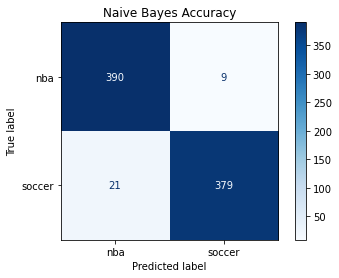

In [109]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Naive Bayes Accuracy');

#plt.savefig('NB_accuracy_matrix.jpg')

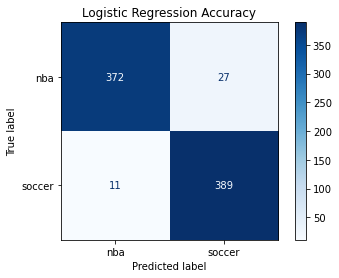

In [110]:
plot_confusion_matrix(pipe2, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Logistic Regression Accuracy');

#plt.savefig('LR_accuracy_matrix.jpg')